In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from skimage.io import imread, imshow
from skimage import io
import pydicom


##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [3]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load sample data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
366,00001951_000.png,No Finding,0,1951,022Y,M,AP,3056,2544,0.139,0.139
2429,00012175_001.png,No Finding,1,12175,042Y,M,PA,2992,2991,0.143,0.143
4263,00021023_011.png,No Finding,11,21023,017Y,F,AP,3056,2544,0.139,0.139


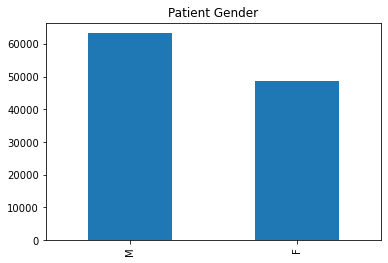

In [4]:
all_xray_df['Patient Gender'].value_counts().plot(kind = 'bar', title = 'Patient Gender')

**The dataset has approximately the same number of men and women and not baised for a certain gender**

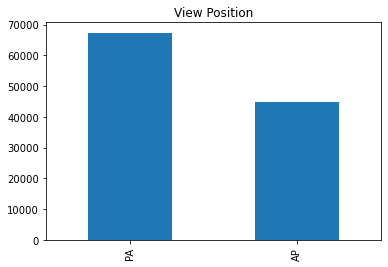

In [5]:
all_xray_df['View Position'].value_counts().plot(kind = 'bar', title = 'View Position')

**The data set has approximately the same number of PA and AP and not baised for a certain poisition**

Text(0.5, 1.0, 'Patient Age')

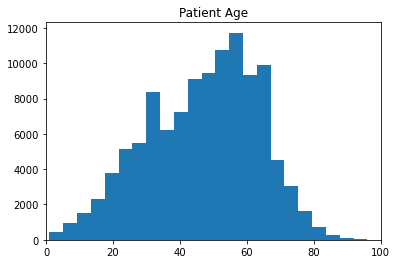

In [6]:
plt.hist(all_xray_df['Patient Age'], bins= 100)
plt.xlim((0,100))
plt.title('Patient Age')

**The data set has people with age varing from 5 to 85**

In [7]:
## Here I'm just going to split up my "Finding Labels" column so that I have one column in my dataframe
# per disease, with a binary flag. This makes EDA a lot easier! 

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)


All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [8]:
len(all_labels)

15

**I see here that there are 15 unique types of labels found in my dataset**

In [9]:
all_xray_df[all_labels].sum()/len(all_xray_df)

Atelectasis           0.103095
Cardiomegaly          0.024759
Consolidation         0.041625
Edema                 0.020540
Effusion              0.118775
Emphysema             0.022440
Fibrosis              0.015037
Hernia                0.002025
Infiltration          0.177435
Mass                  0.051570
No Finding            0.538361
Nodule                0.056466
Pleural_Thickening    0.030191
Pneumonia             0.012763
Pneumothorax          0.047289
dtype: float64

**The dataset has only 1.2% pneumonia cases and need to be balanced** 

[Text(0.5, 1.0, 'Deseases Distribution')]

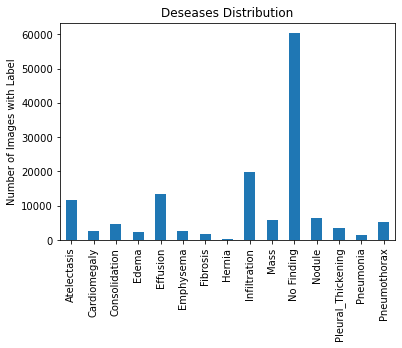

In [10]:
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')
ax.set(title = 'Deseases Distribution')

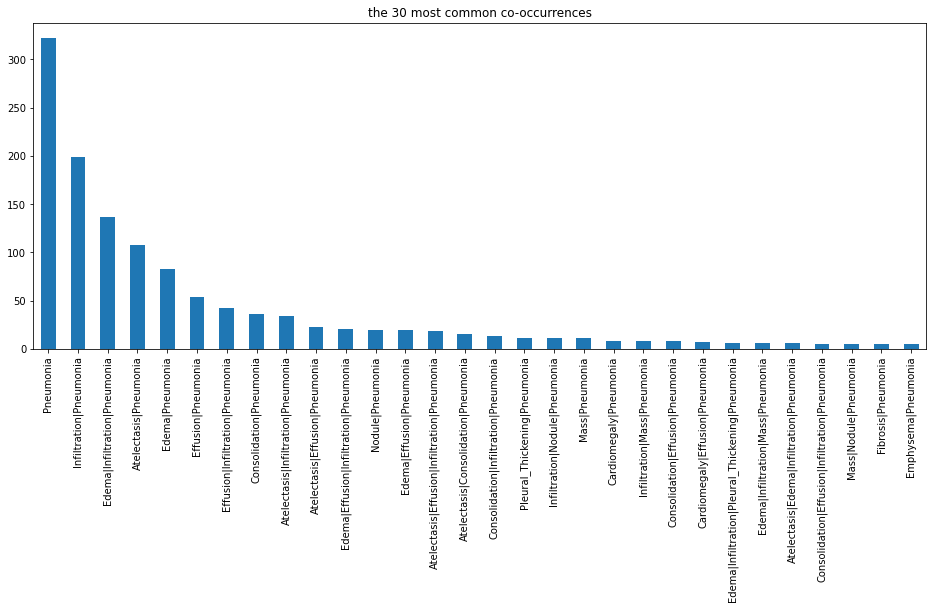

In [11]:
##Since there are many combinations of potential findings, I'm going to look at the 30 most common co-occurrences:
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar', title = 'the 30 most common co-occurrences')

In [12]:
# number of disease per patient
all_xray_df ['number_of_disease'] = all_xray_df[all_labels].sum(axis=1).where(all_xray_df['No Finding'] == 0, 0)

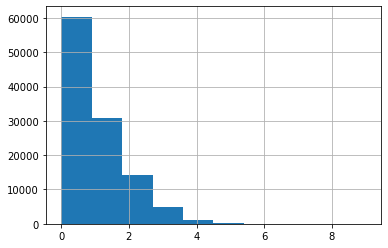

In [13]:
all_xray_df ['number_of_disease'].hist()

In [14]:
sample_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [15]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', sample_df.shape[0])
sample_df['path'] = sample_df['Image Index'].map(all_image_paths.get)
sample_df.sample()

Scans found: 112120 , Total Headers 5606


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
5412,00029259_009.png,Infiltration|Pneumothorax,9,29259,035Y,F,PA,2021,2021,0.194311,0.194311,/data/images_012/images/00029259_009.png


In [16]:
## Here I'm just going to split up my "Finding Labels" column so that I have one column in my dataframe
# per disease, with a binary flag. This makes EDA a lot easier! 

all_labels = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)


All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [17]:
sample_df.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
1085,00005698_001.png,No Finding,1,5698,045Y,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4163,00020438_014.png,No Finding,14,20438,029Y,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3097,00015247_002.png,No Finding,2,15247,055Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4111,00020248_006.png,No Finding,6,20248,026Y,F,AP,3056,2520,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1289,00006752_006.png,No Finding,6,6752,048Y,M,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


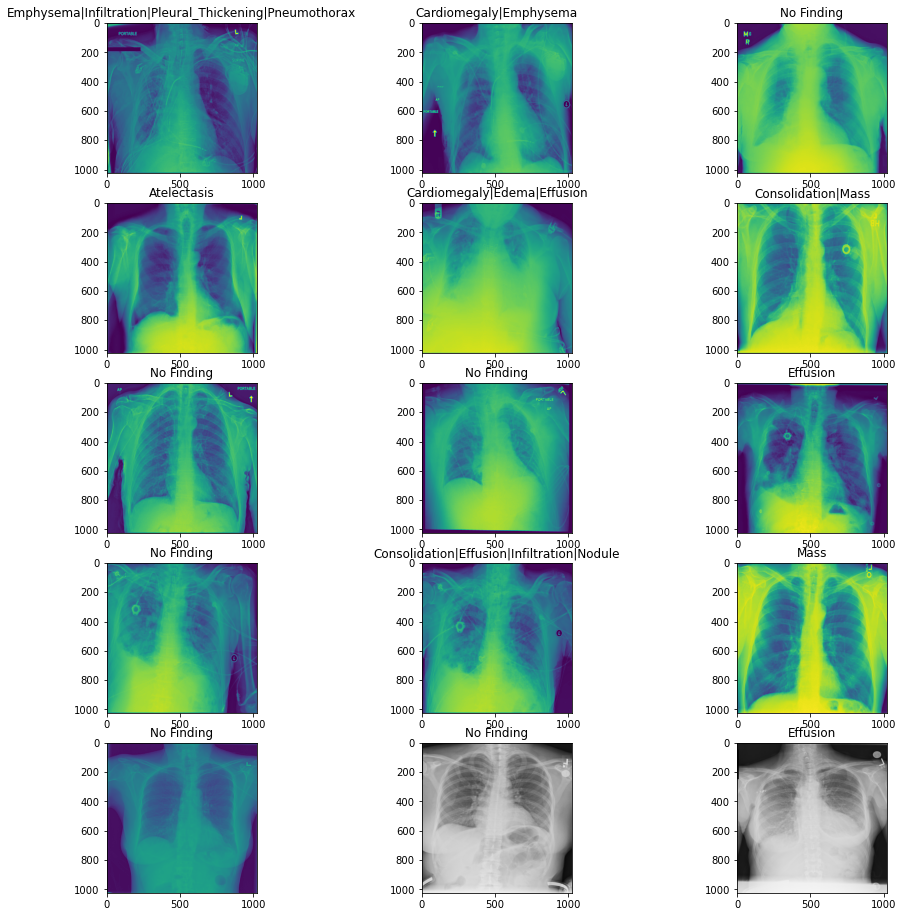

In [18]:
fig, m_axs = plt.subplots(5,3, figsize = (16, 16))
m_axs = m_axs.flatten()
imgs = sample_df.path.head(15)
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)    
    ax.imshow(img)
    ax.set_title(sample_df.iloc[ind]['Finding Labels'])
    ind=ind+1

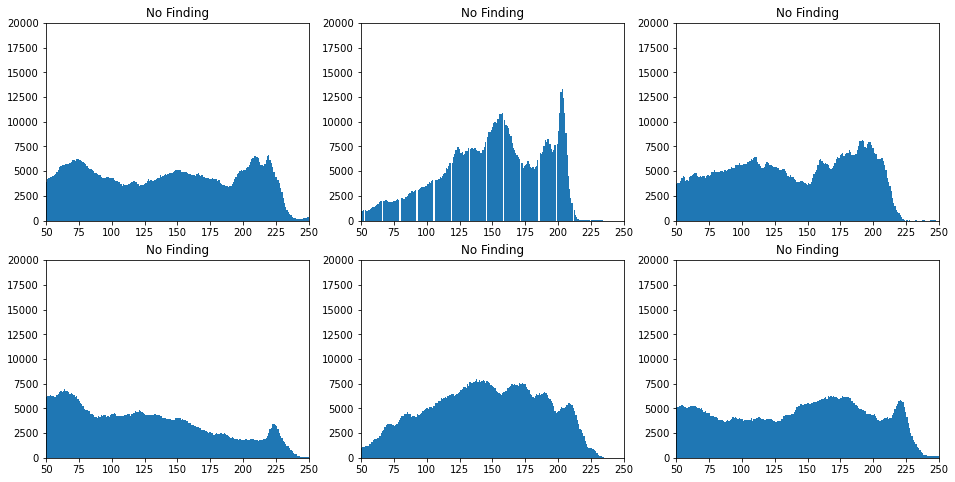

In [19]:
fig, m_axs = plt.subplots(2,3, figsize = (16, 8))
m_axs = m_axs.flatten()
sub_dataset = sample_df[sample_df['Finding Labels']=='No Finding'].sample(6)
imgs = sub_dataset.path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.hist(img.ravel(), bins = 256)
    ax.set_title(sub_dataset.iloc[ind]['Finding Labels'])
    ax.set(xlim=(50,250))
    ax.set(ylim=(0,20000))
    ind=ind+1

**The max intensty for No finding image are arround 150**

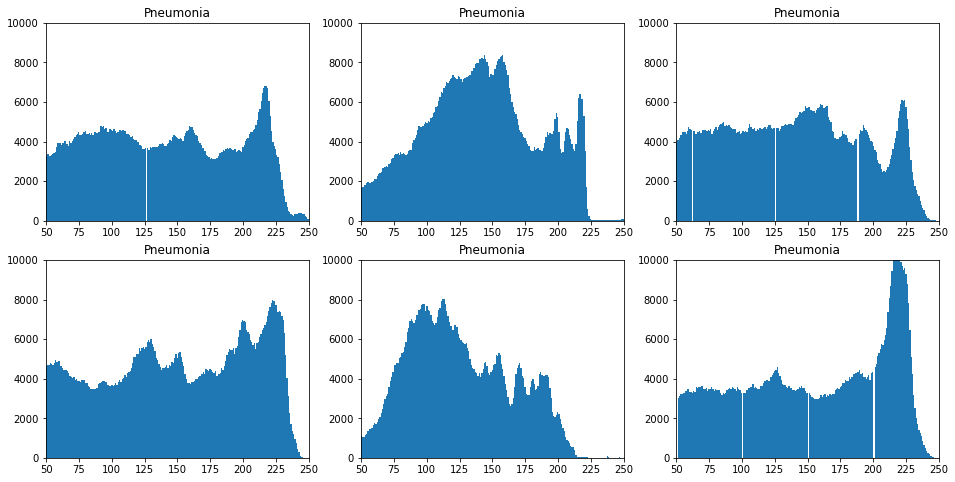

In [20]:
fig, m_axs = plt.subplots(2,3, figsize = (16, 8))
m_axs = m_axs.flatten()
sub_dataset = sample_df[sample_df['Finding Labels']=='Pneumonia'].sample(6)
imgs = sub_dataset.path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.hist(img.ravel(), bins = 256)
    ax.set_title(sub_dataset.iloc[ind]['Finding Labels'])
    ax.set(xlim=(50,250))
    ax.set(ylim=(0,10000))
    ind=ind+1

**Pneumonia: The maximum entinisty is lower than 10000 with two picks around 150 and 225**

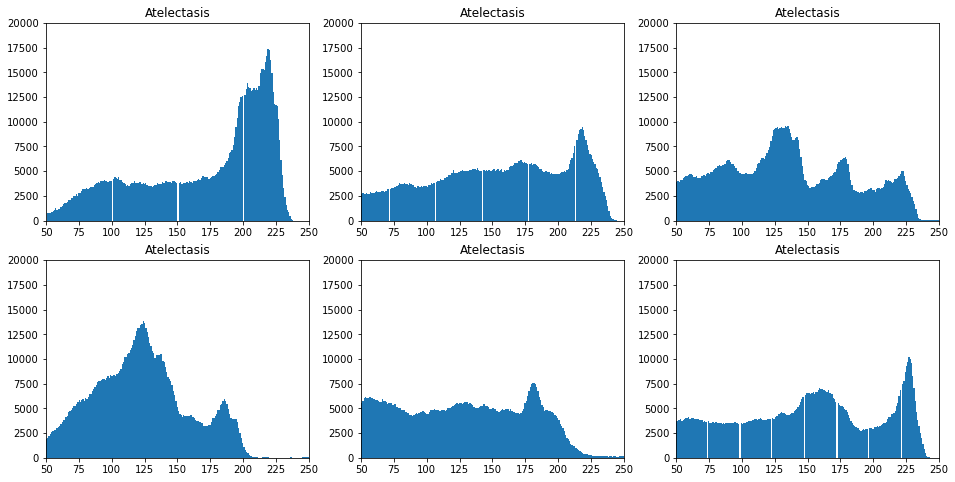

In [21]:
fig, m_axs = plt.subplots(2,3, figsize = (16, 8))
m_axs = m_axs.flatten()
sub_dataset = sample_df[sample_df['Finding Labels']=='Atelectasis'].sample(6)
imgs = sub_dataset.path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.hist(img.ravel(), bins = 256)
    ax.set_title(sub_dataset.iloc[ind]['Finding Labels'])
    ax.set(xlim=(50,250))
    ax.set(ylim=(0,20000))
    ind=ind+1

**Atelectasis: The maximum entinisty is lower than 10000 with a picks between 150 and 175**

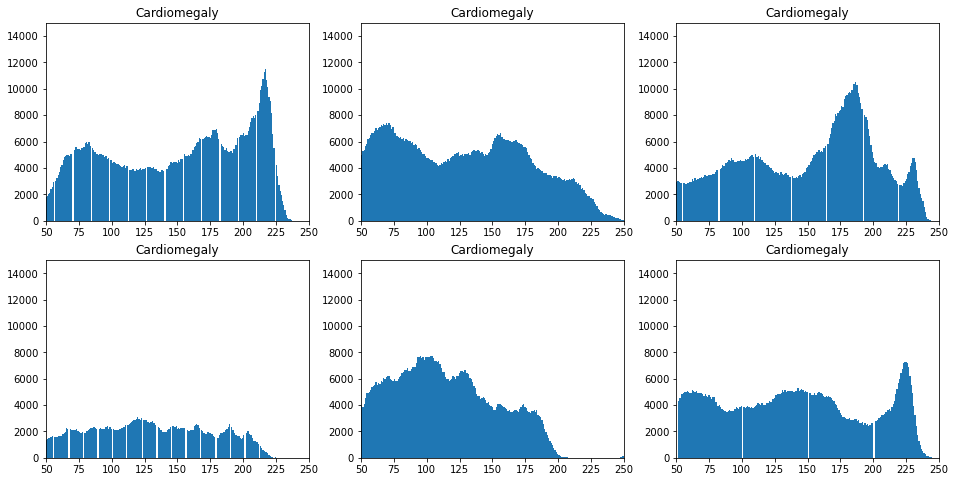

In [22]:
fig, m_axs = plt.subplots(2,3, figsize = (16, 8))
m_axs = m_axs.flatten()
sub_dataset = sample_df[sample_df['Finding Labels']=='Cardiomegaly'].sample(6)
imgs = sub_dataset.path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.hist(img.ravel(), bins = 256)
    ax.set_title(sub_dataset.iloc[ind]['Finding Labels'])
    ax.set(xlim=(50,250))
    ax.set(ylim=(0,15000))
    ind=ind+1

**Cardiomegaly: The maximum entinisty is lower than 10000 with a picks between 75 and 125**

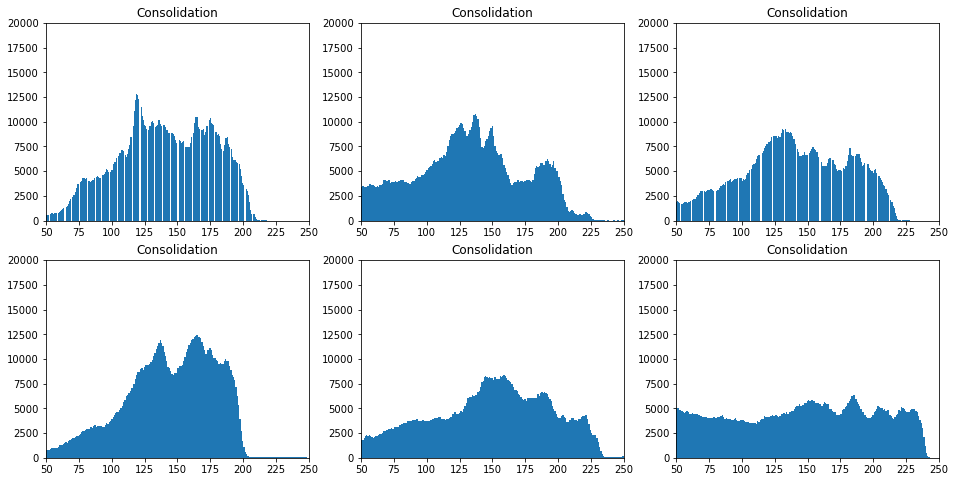

In [23]:
fig, m_axs = plt.subplots(2,3, figsize = (16, 8))
m_axs = m_axs.flatten()
sub_dataset = sample_df[sample_df['Finding Labels']=='Consolidation'].sample(6)
imgs = sub_dataset.path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.hist(img.ravel(), bins = 256)
    ax.set_title(sub_dataset.iloc[ind]['Finding Labels'])
    ax.set(xlim=(50,250))
    ax.set(ylim=(0,20000))
    ind=ind+1

Consolidation: The maximum entinisty is lower than 10000 with a picks 225

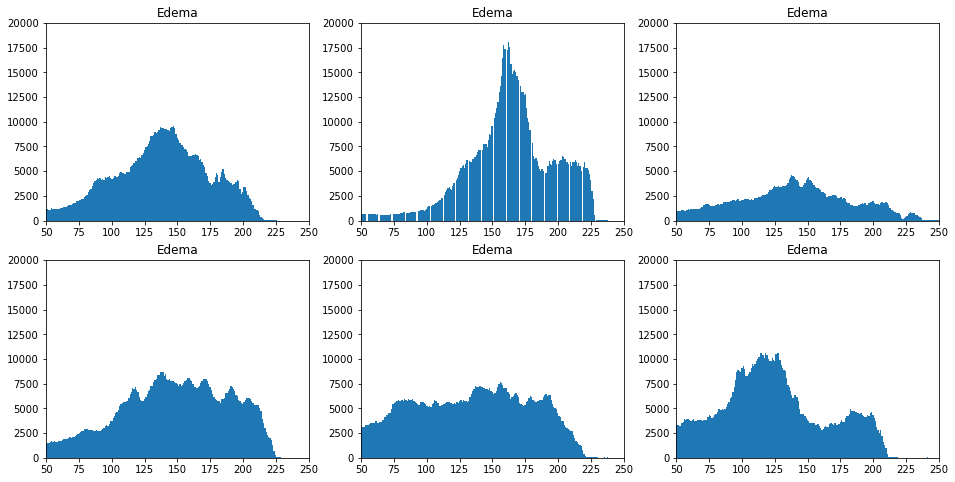

In [24]:
fig, m_axs = plt.subplots(2,3, figsize = (16, 8))
m_axs = m_axs.flatten()
sub_dataset = sample_df[sample_df['Finding Labels']=='Edema'].sample(6)
imgs = sub_dataset.path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.hist(img.ravel(), bins = 256)
    ax.set_title(sub_dataset.iloc[ind]['Finding Labels'])
    ax.set(xlim=(50,250))
    ax.set(ylim=(0,20000))
    ind=ind+1

Edema: The maximum entinsity is lower than 10000 with a pick around 125 

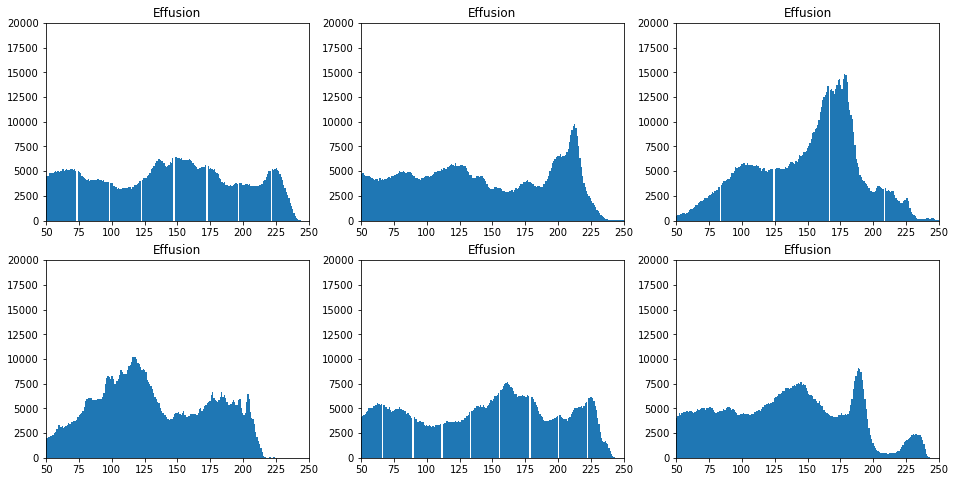

In [25]:
fig, m_axs = plt.subplots(2,3, figsize = (16, 8))
m_axs = m_axs.flatten()
sub_dataset = sample_df[sample_df['Finding Labels']=='Effusion'].sample(6)
imgs = sub_dataset.path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.hist(img.ravel(), bins = 256)
    ax.set_title(sub_dataset.iloc[ind]['Finding Labels'])
    ax.set(xlim=(50,250))
    ax.set(ylim=(0,20000))
    ind=ind+1

Effusion: The maximum entinsity is higher than 10000 with a pick around 125

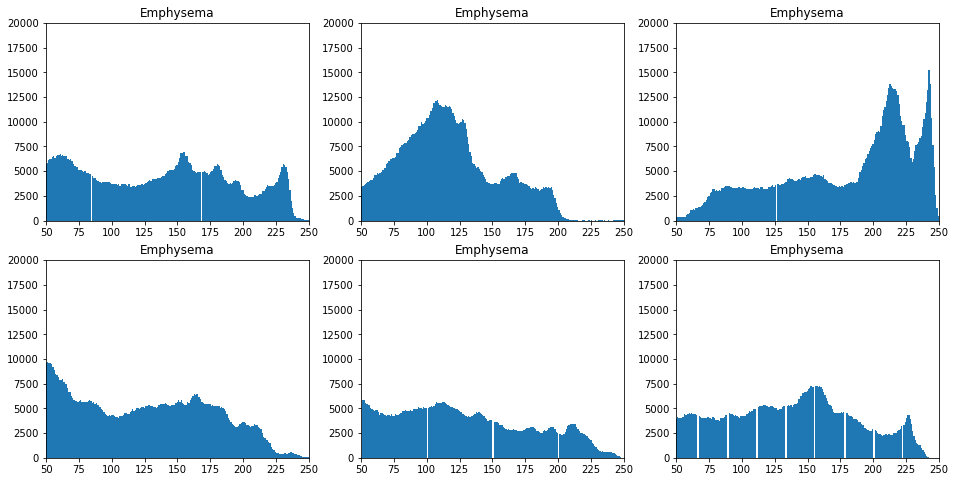

In [99]:
fig, m_axs = plt.subplots(2,3, figsize = (16, 8))
m_axs = m_axs.flatten()
sub_dataset = sample_df[sample_df['Finding Labels']=='Emphysema'].sample(6)
imgs = sub_dataset.path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.hist(img.ravel(), bins = 256)
    ax.set_title(sub_dataset.iloc[ind]['Finding Labels'])
    ax.set(xlim=(50,250))
    ax.set(ylim=(0,20000))
    ind=ind+1

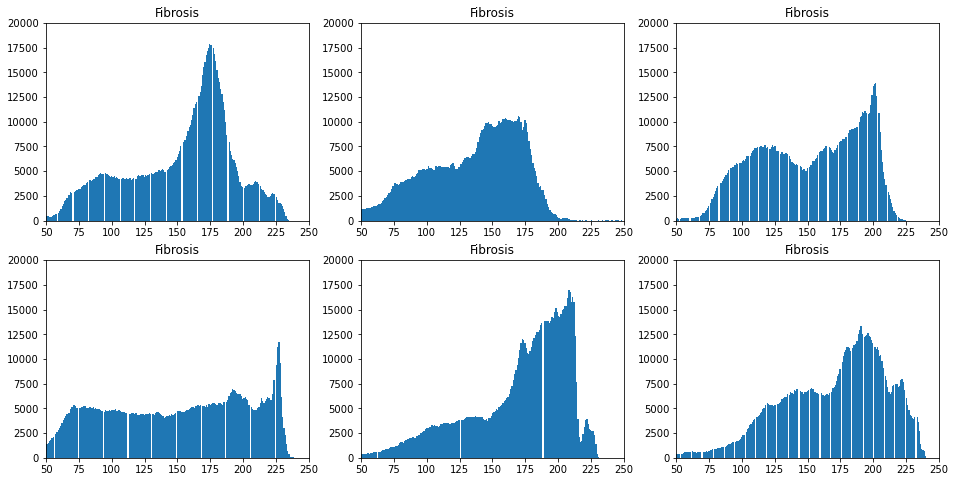

In [101]:
fig, m_axs = plt.subplots(2,3, figsize = (16, 8))
m_axs = m_axs.flatten()
sub_dataset = sample_df[sample_df['Finding Labels']=='Fibrosis'].sample(6)
imgs = sub_dataset.path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.hist(img.ravel(), bins = 256)
    ax.set_title(sub_dataset.iloc[ind]['Finding Labels'])
    ax.set(xlim=(50,250))
    ax.set(ylim=(0,20000))
    ind=ind+1

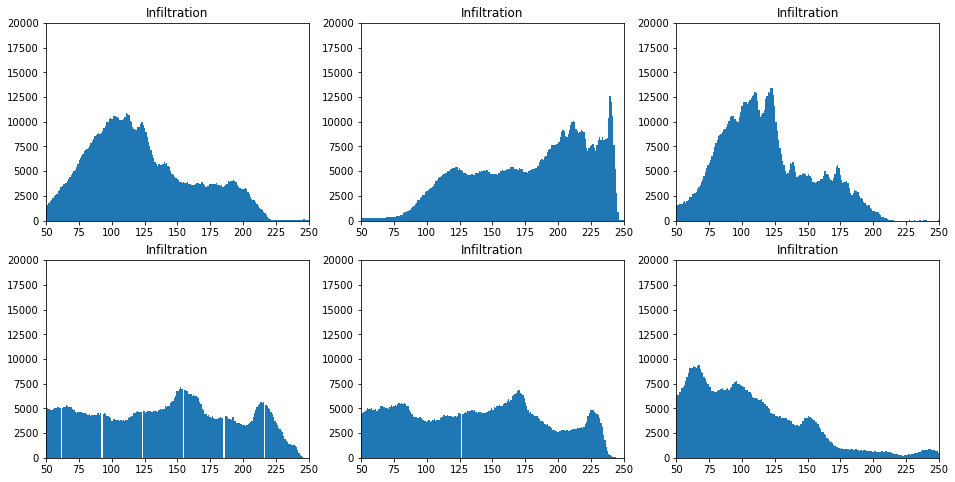

In [103]:
fig, m_axs = plt.subplots(2,3, figsize = (16, 8))
m_axs = m_axs.flatten()
sub_dataset = sample_df[sample_df['Finding Labels']=='Infiltration'].sample(6)
imgs = sub_dataset.path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.hist(img.ravel(), bins = 256)
    ax.set_title(sub_dataset.iloc[ind]['Finding Labels'])
    ax.set(xlim=(50,250))
    ax.set(ylim=(0,20000))
    ind=ind+1

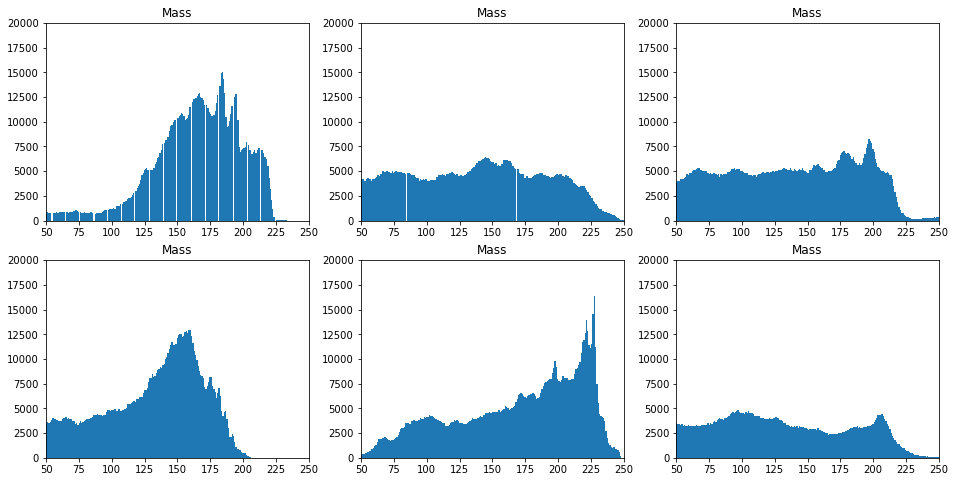

In [104]:
fig, m_axs = plt.subplots(2,3, figsize = (16, 8))
m_axs = m_axs.flatten()
sub_dataset = sample_df[sample_df['Finding Labels']=='Mass'].sample(6)
imgs = sub_dataset.path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.hist(img.ravel(), bins = 256)
    ax.set_title(sub_dataset.iloc[ind]['Finding Labels'])
    ax.set(xlim=(50,250))
    ax.set(ylim=(0,20000))
    ind=ind+1

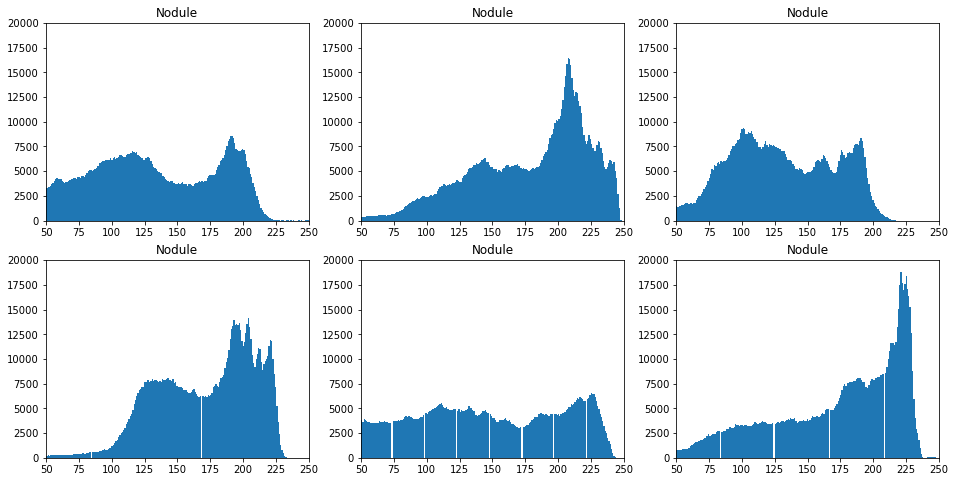

In [106]:
fig, m_axs = plt.subplots(2,3, figsize = (16, 8))
m_axs = m_axs.flatten()
sub_dataset = sample_df[sample_df['Finding Labels']=='Nodule'].sample(6)
imgs = sub_dataset.path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.hist(img.ravel(), bins = 256)
    ax.set_title(sub_dataset.iloc[ind]['Finding Labels'])
    ax.set(xlim=(50,250))
    ax.set(ylim=(0,20000))
    ind=ind+1

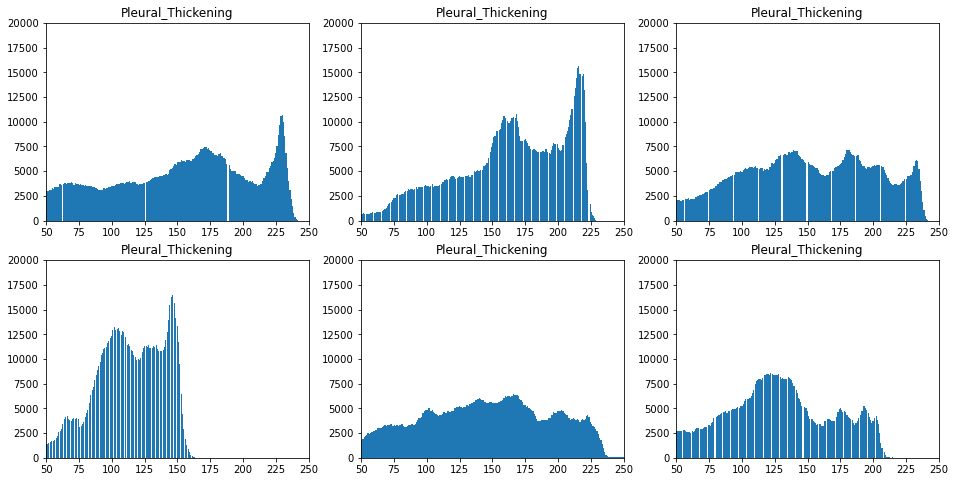

In [107]:
fig, m_axs = plt.subplots(2,3, figsize = (16, 8))
m_axs = m_axs.flatten()
sub_dataset = sample_df[sample_df['Finding Labels']=='Pleural_Thickening'].sample(6)
imgs = sub_dataset.path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.hist(img.ravel(), bins = 256)
    ax.set_title(sub_dataset.iloc[ind]['Finding Labels'])
    ax.set(xlim=(50,250))
    ax.set(ylim=(0,20000))
    ind=ind+1

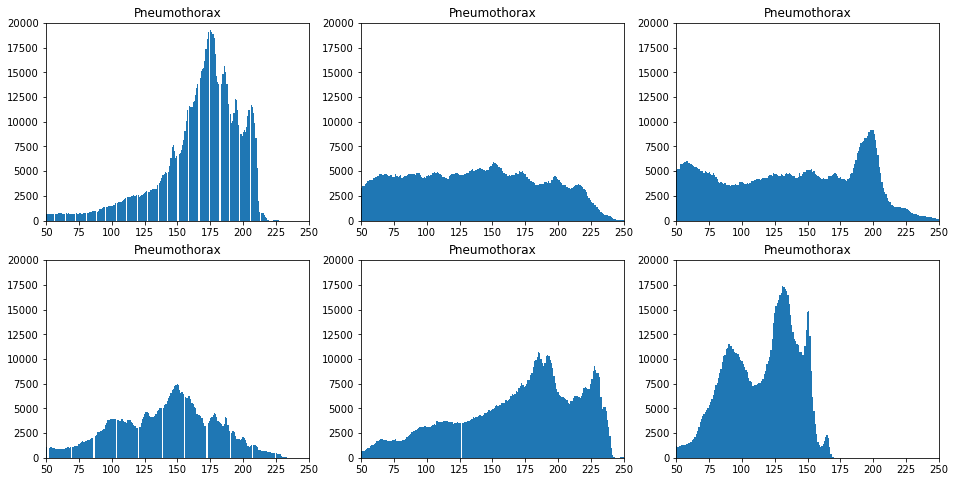

In [108]:
fig, m_axs = plt.subplots(2,3, figsize = (16, 8))
m_axs = m_axs.flatten()
sub_dataset = sample_df[sample_df['Finding Labels']=='Pneumothorax'].sample(6)
imgs = sub_dataset.path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.hist(img.ravel(), bins = 256)
    ax.set_title(sub_dataset.iloc[ind]['Finding Labels'])
    ax.set(xlim=(50,250))
    ax.set(ylim=(0,20000))
    ind=ind+1

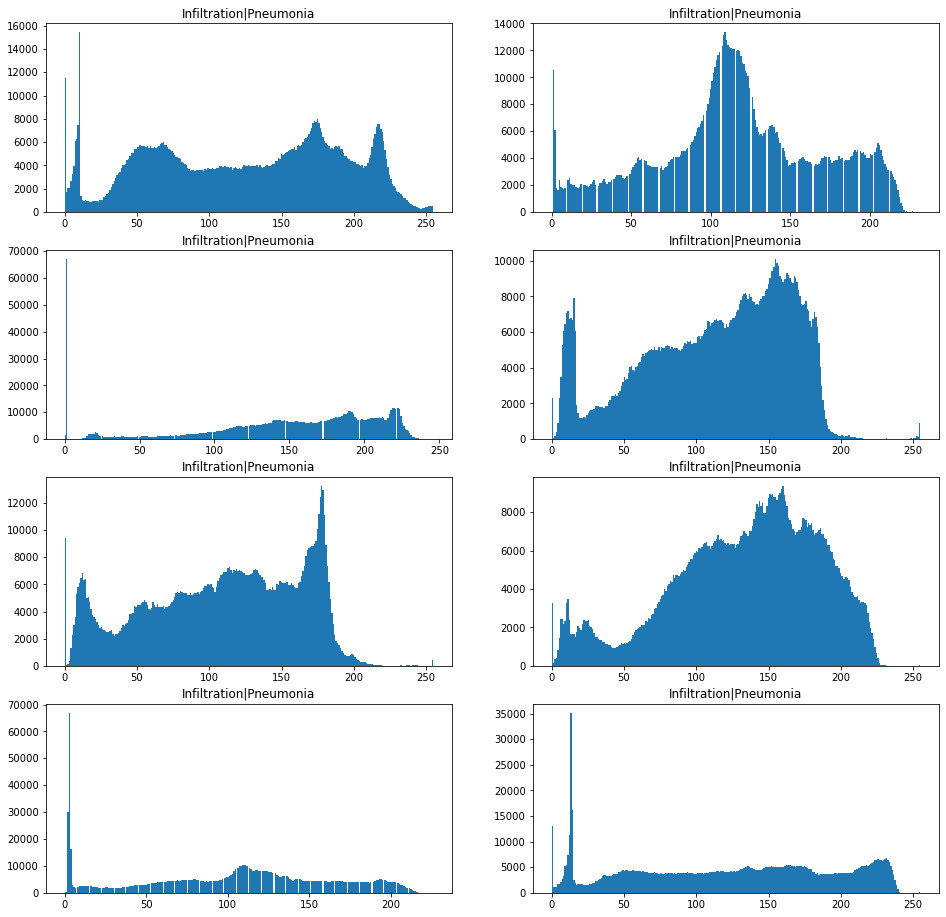

In [46]:
fig, m_axs = plt.subplots(4,2, figsize = (16, 16))
m_axs = m_axs.flatten()
sub_dataset = sample_df[sample_df['Finding Labels']=='Infiltration|Pneumonia']
imgs = sub_dataset.path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.hist(img.ravel(), bins = 256)
    ax.set_title(sub_dataset.iloc[ind]['Finding Labels'])
    ind=ind+1

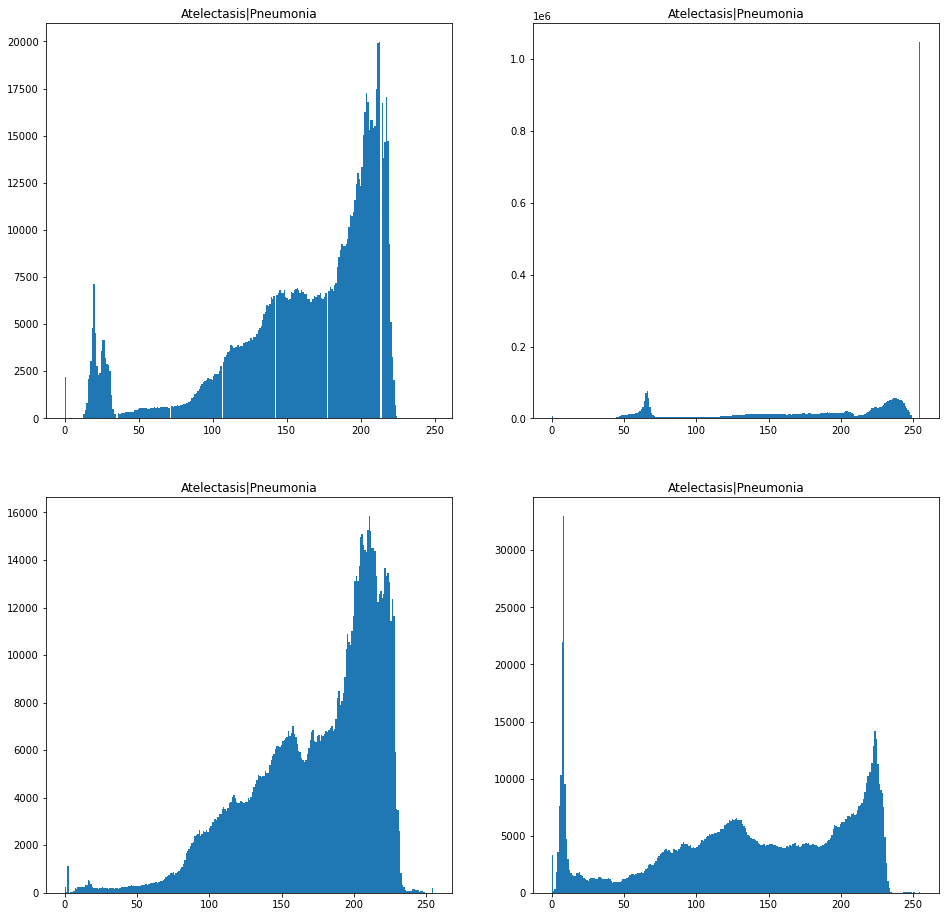

In [48]:
fig, m_axs = plt.subplots(2,2, figsize = (16, 16))
m_axs = m_axs.flatten()
sub_dataset = sample_df[sample_df['Finding Labels']=='Atelectasis|Pneumonia']
imgs = sub_dataset.path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.hist(img.ravel(), bins = 256)
    ax.set_title(sub_dataset.iloc[ind]['Finding Labels'])
    ind=ind+1

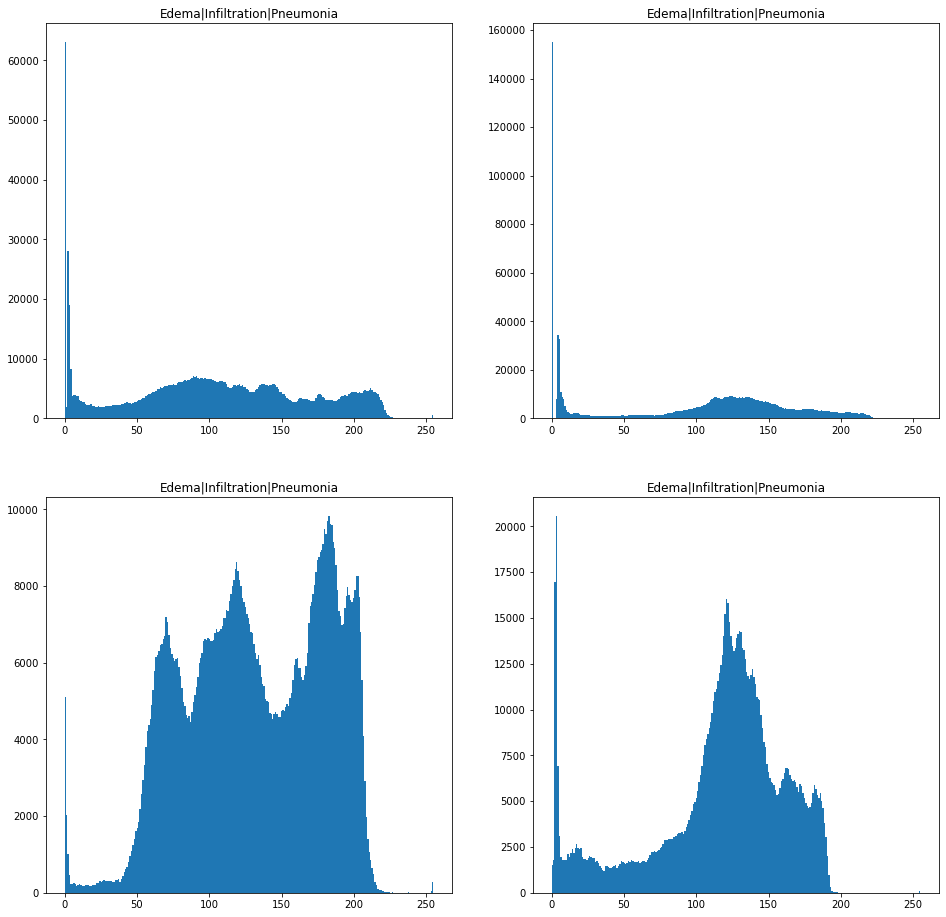

In [49]:
fig, m_axs = plt.subplots(2,2, figsize = (16, 16))
m_axs = m_axs.flatten()
sub_dataset = sample_df[sample_df['Finding Labels']=='Edema|Infiltration|Pneumonia']
imgs = sub_dataset.path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.hist(img.ravel(), bins = 256)
    ax.set_title(sub_dataset.iloc[ind]['Finding Labels'])
    ind=ind+1

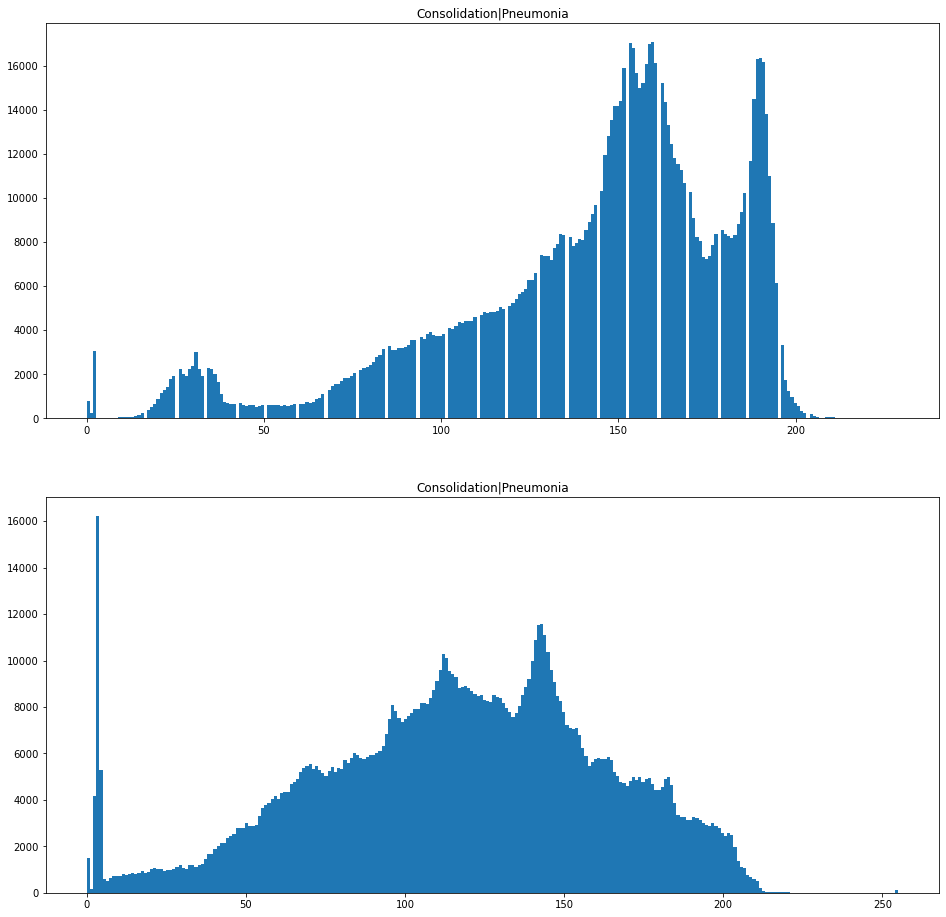

In [50]:
fig, m_axs = plt.subplots(2,1, figsize = (16, 16))
m_axs = m_axs.flatten()
sub_dataset = sample_df[sample_df['Finding Labels']=='Consolidation|Pneumonia']
imgs = sub_dataset.path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.hist(img.ravel(), bins = 256)
    ax.set_title(sub_dataset.iloc[ind]['Finding Labels'])
    ind=ind+1

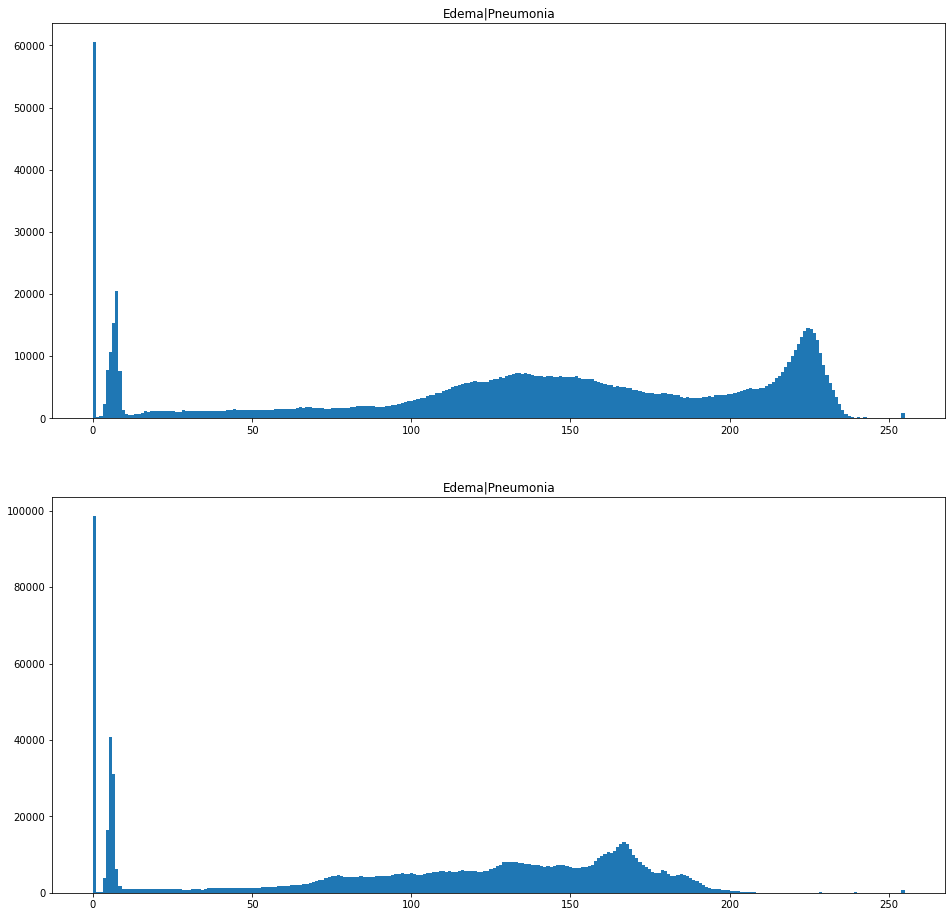

In [51]:
fig, m_axs = plt.subplots(2,1, figsize = (16, 16))
m_axs = m_axs.flatten()
sub_dataset = sample_df[sample_df['Finding Labels']=='Edema|Pneumonia']
imgs = sub_dataset.path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.hist(img.ravel(), bins = 256)
    ax.set_title(sub_dataset.iloc[ind]['Finding Labels'])
    ind=ind+1

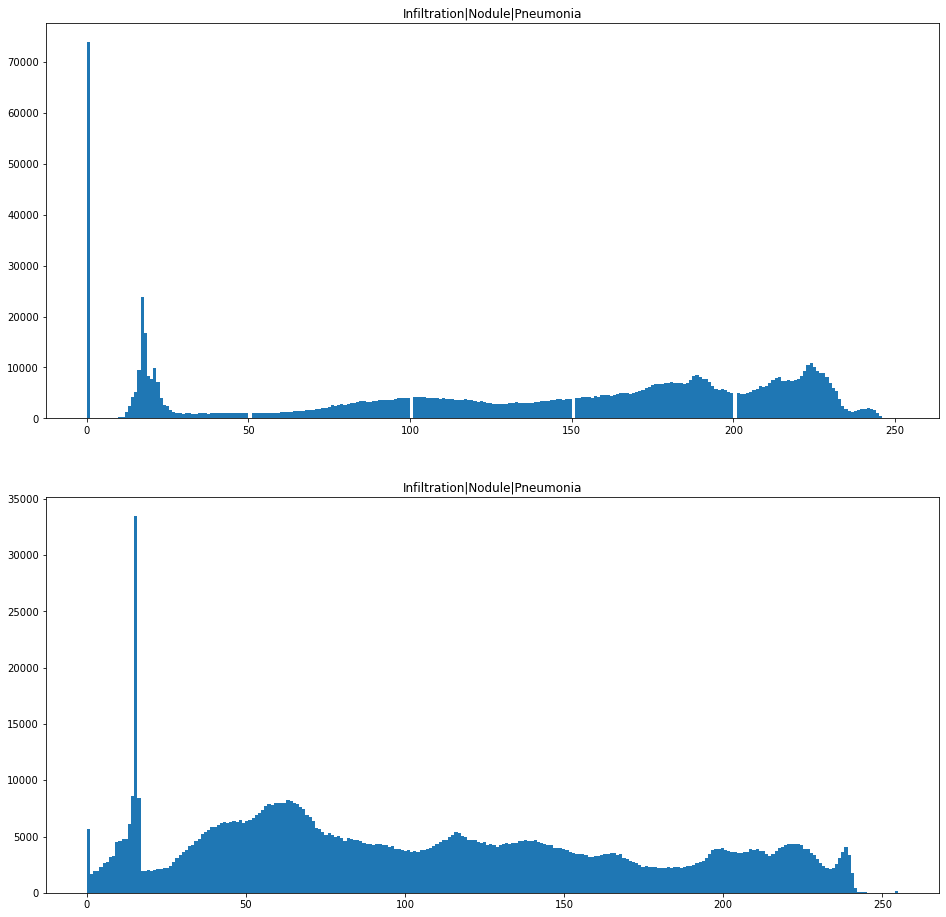

In [52]:
fig, m_axs = plt.subplots(2,1, figsize = (16, 16))
m_axs = m_axs.flatten()
sub_dataset = sample_df[sample_df['Finding Labels']=='Infiltration|Nodule|Pneumonia']
imgs = sub_dataset.path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.hist(img.ravel(), bins = 256)
    ax.set_title(sub_dataset.iloc[ind]['Finding Labels'])
    ind=ind+1

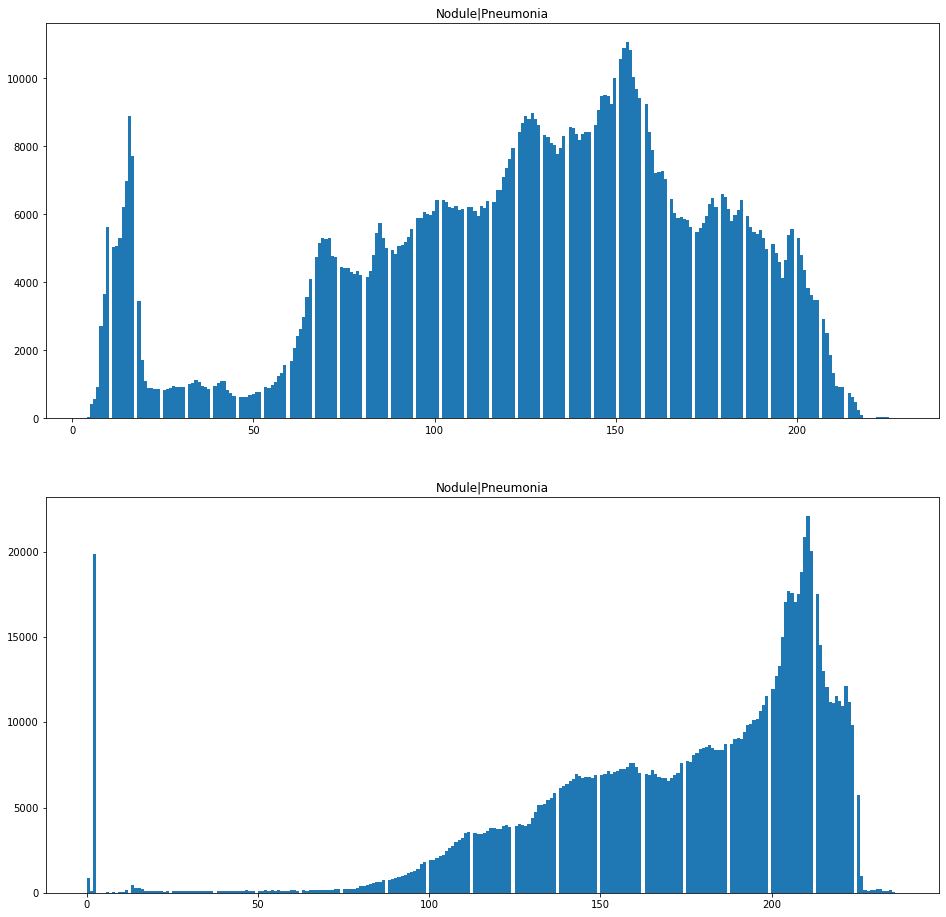

In [109]:
fig, m_axs = plt.subplots(2,1, figsize = (16, 16))
m_axs = m_axs.flatten()
sub_dataset = sample_df[sample_df['Finding Labels']=='Nodule|Pneumonia']
imgs = sub_dataset.path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.hist(img.ravel(), bins = 256)
    ax.set_title(sub_dataset.iloc[ind]['Finding Labels'])
    ind=ind+1

### No finding Images:
- **They have peaks intensity between 160 and 180**
- **Their peaks are actually all about eleven handred to eighteen handred pixels**
- **Another peak is between 200 and 225**

### Pneumonia Images:
- **The maximum entinsity is lower than 10000**
- **They have two picks around 150 and 225**

**From the intensity destripution study, the threshold value will play an important role in the classification** 
